# A primer into TD Learning Algorithms using the Open AI Gym

Machine Learning is commonly classified in: i) supervised learning, ii) unsupervised learning and iii) reinforcement learning. Reinforcement learning differs from the supervised and unsupervised learning as the data we are trying to extract a model from is: neither labeled I/O pairs (supervised) from which we want to extract a function approximator nor unlabeled items (i.e., feature vectors) on which we desire identifying a relationship or schema by computing a distance (or viceversa similarity) measure. RL algorithms are types of simulation-based learning algorithms since they commonly require an agent interacting with its environment in order to perceive (with its sensors) a more or less observable environment state, formulate a plan (i.e., a sequence of actions) and actuate them to steer the environment to a different state.

![rl-agent](https://upload.wikimedia.org/wikipedia/commons/thumb/1/1b/Reinforcement_learning_diagram.svg/300px-Reinforcement_learning_diagram.svg.png)

The basic agent representation is the Markov decision process (MDP), consisting in a set of fully-observable states (i.e., deterministically detected by the agent) connected each other by actions: i) taken by the agent in each state and ii) a stochastic model of the environment, which is probabilistically reacting to the agent. 
The agent acts based on a task, i.e., he strives for optimizing an objective function, which in the discrete sense can be intended as achieving a certain environment configuration or state. Consequently, the task can have either a continuous (in time terms) or episodic nature, i.e., once achieved certain terminal states the agent's task ends. 
The agent task is expressed by means of a reward function, returned by the environment after each action.

In real life it is not only the environment reaction to be stochastic (i.e. the actuation) but also the perception (i.e., available sensors might yield errors or not be enought to observe certain phenomena), thus leading to more complex mathematical frameworks, such a partially-observable MDPs, or PO-MDPs. The framework can also be further complicated by adding multiple agents and other constraints, but this goes outside the scope of this notebook.

The goal of RL algorithms is therefore to learn a policy, defined as: i) a utility value related to each environment state, ii) a state-action pair function mapping the pair to the expected utility of taking a certain action in a specific state. When learning a policy two main aspects need to be considered: i) in the action selection strategy the exploitaion-exploration balance between running the action that leads highest expected reward and randomly selecting a suboptimal one that might eventually lead to higher cumulative reward; ii) in the backing of the achieved reward the "credit assignment problem", for which in real world rewards are typically delayed and the agent has to distinguish which actions in the sequence actually lead to the reward, and which instead made it diverge from it. This is typically done by assigning to an action the reward received for the actions that followed, since it would not have been possible by taking a different path. A discount factor is normally employed to give higher weight to closer (to current state) actions in the sequence.

Please check the following links for a more complete understanding: 

RL Introduction
* S.Russel, P.Norwig. Artificial Intelligence: a modern approach. Pearson 2010 (3rd edition)
* R. S. Sutton and A. G. Barto. Reinforcement Learning: An Introduction. MIT press 1998
* C. Szepesvari. Algorithms for Reinforcement Learning. Morgan & Claypool publishers

Multiagent RL
* N.Nisan, T.Roughgarden, E.Tardos, V.V.Vazirani. Algorithmic game theory. Cambridge press 2007 
* G.Weiss (editor). Multi agent systems. MIT press 2013

## OpenAI Gym
The OpenAI Gym (https://github.com/openai/gym) is an environment specifically made to model control tasks and allow for the comparison of RL algorithms. 

Let's install it:  
`python2.7 -m pip install -U --user gym`

We can also install specific modules, such as the Atari environments or just everything:  
`python2.7 -m pip install -U --user gym[atari]`  
`python2.7 -m pip install -U --user gym[all]`

In [1]:
%matplotlib inline
import gym
import numpy as np
from matplotlib import pyplot
from matplotlib.pyplot import imshow

from keras import backend as K
print K.image_data_format()
K.set_image_data_format('channels_last')

Using TensorFlow backend.


channels_last


## 1. Selecting the environment

Let's list all available environments:

In [2]:
from gym import envs
print(envs.registry.all())

[EnvSpec(RoadRunner-ramDeterministic-v4), EnvSpec(Asteroids-ramDeterministic-v0), EnvSpec(Gopher-ramDeterministic-v4), EnvSpec(RoadRunner-ramDeterministic-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(Gopher-ramDeterministic-v0), EnvSpec(DoubleDunk-ramDeterministic-v4), EnvSpec(DoubleDunk-ramDeterministic-v0), EnvSpec(Robotank-ram-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(Asteroids-ramDeterministic-v4), EnvSpec(Pooyan-ram-v4), EnvSpec(Gopher-ram-v0), EnvSpec(Pooyan-ram-v0), EnvSpec(Gopher-ram-v4), EnvSpec(Pong-ramNoFrameskip-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(YarsRevenge-ramDeterministic-v4), EnvSpec(CarRacing-v0), EnvSpec(SpaceInvaders-ram-v0), EnvSpec(YarsRevenge-ramDeterministic-v0), EnvSpec(SpaceInvadersDeterministic-v0), EnvSpec(DoubleDunk-ram-v0), EnvSpec(SpaceInvadersDeterministic-v4), EnvSpec(DoubleDunk-ram-v4), EnvSpec(VideoPinballDeterministic-v0), EnvSpec(Centipede-v0), EnvSpec(Centipede-v4), EnvSpec(YarsRevenge-v4), EnvSpec(Pitfall-ramNoFrameskip-v0

To start a standard environment the method make can be used:

In [3]:
env_id = "MsPacmanDeterministic-v4"
env = gym.make(env_id)

#env = gym.make('CartPole-v0')

[2018-11-20 14:40:53,781] Making new env: MsPacmanDeterministic-v4


In [4]:
print dir(env)

['__class__', '__del__', '__delattr__', '__dict__', '__doc__', '__format__', '__getattribute__', '__hash__', '__init__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_close', '_closed', '_elapsed_seconds', '_elapsed_steps', '_ensure_no_double_wrap', '_env_closer_id', '_episode_started_at', '_max_episode_seconds', '_max_episode_steps', '_owns_render', '_past_limit', '_render', '_reset', '_seed', '_spec', '_step', 'action_space', 'class_name', 'close', 'configure', 'env', 'metadata', 'observation_space', 'render', 'reset', 'reward_range', 'seed', 'spec', 'step', 'unwrapped']


The method close removes the environment:

In [5]:
env.close()

## 2. Running an example experiment

Most important in every reproducible experiment is to set a seed for the random generator:

In [6]:
initial_seed = 1234

Let's run a pacman environment and where we select random actions until the agent dies or clears the level.

In [7]:
# reset the environment to the initial state
#env_id = "MsPacman-v0"
env = gym.make(env_id)

observation = env.reset()

np.random.seed(initial_seed)
env.seed(initial_seed)

print "action space", env.action_space
print "actions", env.env.get_action_meanings()
print "observation space", env.observation_space

done = False
info = None
total_reward = 0
while (not done) and (info is None or info['ale.lives'] == 3):
    # update environment
    env.render()
    # select random action from the action space
    action = env.action_space.sample()
    # apply action on the environment
    # get back the observation of the destination state, the reward, if terminal state was reached
    observation, reward, done, info = env.step(action)
    total_reward += reward
    
if info['ale.lives'] == 2:
    print "The agent has died"
print "Total reward", total_reward
env.close()

[2018-11-20 14:40:57,849] Making new env: MsPacmanDeterministic-v4


action space Discrete(9)
actions ['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']
observation space Box(210, 160, 3)
The agent has died
Total reward 150.0


In [8]:
print env.metadata
print dir(env)

{'render.modes': ['human', 'rgb_array']}
['__class__', '__del__', '__delattr__', '__dict__', '__doc__', '__format__', '__getattribute__', '__hash__', '__init__', '__module__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_close', '_closed', '_elapsed_seconds', '_elapsed_steps', '_ensure_no_double_wrap', '_env_closer_id', '_episode_started_at', '_max_episode_seconds', '_max_episode_steps', '_owns_render', '_past_limit', '_render', '_reset', '_seed', '_spec', '_step', 'action_space', 'class_name', 'close', 'configure', 'env', 'metadata', 'observation_space', 'render', 'reset', 'reward_range', 'seed', 'spec', 'step', 'unwrapped']


## 3. Selecting a Reinforcement Learning library on the top of Keras

Looking for what libraries can seamlessly integrate with Tensorflow & Keras to provide RL functionalities I have found the following:
* RLlab (for OpenAI Gym) - https://github.com/rll/rllab, now renamed Garage - https://github.com/rlworkgroup/garage
* TRFL (Truffle) - https://github.com/deepmind/trfl/
* Tensorforce - https://github.com/reinforceio/tensorforce
* Keras-RL - https://github.com/keras-rl/keras-rl

The first 3 are based on Tensorflow, while only Keras-RL is based on Keras and well integrated with OpenAI Gym.  
Let's install it:  
`python2.7 -m pip install -U --user keras-rl`

## 4. Implementing an RL agent

In [228]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Permute
from keras.constraints import maxnorm
from keras.optimizers import SGD, rmsprop
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.models import clone_model

In [229]:
from keras.optimizers import Adam
from rl.agents.cem import CEMAgent
from rl.agents.dqn import DQNAgent
from rl.memory import EpisodeParameterMemory, SequentialMemory
from rl.policy import LinearAnnealedPolicy, BoltzmannQPolicy, EpsGreedyQPolicy

class Agent():
    def __init__(self, agent_type, env_id, input_shape, window_length, num_actions, optimizer, metrics, 
                 preprocessor=None):
        self.env_id = env_id
        self.preprocessor = preprocessor
        self.model = self.__get__model(input_shape, window_length, num_actions)
        #memory = EpisodeParameterMemory(limit=1000,
        #                                window_length=1)
        memory = SequentialMemory(limit=1000000, window_length=window_length)
        # limit: how many entries the memory can hold, after which older entries will be replaced with newer ones
        # window_length: how many observations are concatenated to form a state
        
        self.agent = self.__get_decision__maker(self.model, num_actions, memory, agent_type=agent_type)
        self.agent.compile(optimizer, metrics)
        
    def __get_decision__maker(self, model, num_actions, memory, agent_type="DQN"):
        if agent_type is "DQN":
            #dqn = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=10, enable_dueling_network=True, dueling_type='avg', target_model_update=1e-2, policy=policy)
            
            policy = LinearAnnealedPolicy(EpsGreedyQPolicy(),
                                          attr='eps',
                                          value_max=1.,
                                          value_min=.1, 
                                          value_test=.05,
                                          nb_steps=1000000)
            a = DQNAgent(model=model,
                         processor=self.preprocessor,
                         nb_actions=num_actions,
                         memory=memory,
                         nb_steps_warmup=2000,
                         policy=policy,
                         test_policy=None,
                         enable_double_dqn=True,
                         enable_dueling_network=False,
                         dueling_type='avg')
        else:
            a = CEMAgent(model=model, 
                         processor=self.preprocessor,
                         nb_actions=num_actions,
                         memory=memory,
                         batch_size=50,
                         nb_steps_warmup=2000,
                         train_interval=50,
                         elite_frac=0.05)
        return a
    
    def __get__model(self, input_shape, window_length, num_actions):
        model = Sequential()
        # ValueError: Error when checking : expected conv2d_82_input to have shape
        # (None, 80, 88, 1) but got array with shape (1, 1, 88, 80)
        # for some reason, keras RL is passing images transposed, i.e., with shape (batch, channel, h, w)
        model.add(Permute((2, 3, 1),
                          input_shape = (window_length,)+input_shape,
                          #data_format = "channels_last", # without this the channel is provided first
                         ))
        model.add(Conv2D(32,
                         (3, 3), 
                         #input_shape=(window_length,)+input_shape,
                         #data_format = "channels_last", # without this the channel is provided first
                         activation='relu'))
        model.add(Dropout(0.25))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2, 2)))
        #model.add(Flatten(input_shape=(1,) + num_sensors))
        model.add(Flatten())
        # add intermediate layers
        model.add(Dense(512, activation="relu"))
        model.add(Dropout(0.35))
        model.add(Dense(256, activation="relu"))
        model.add(Dropout(0.35))
        model.add(Dense(128, activation="relu"))
        model.add(Dropout(0.35))
        # decision layer: softmax
        #model.add(Activation('softmax'))
        model.add(Dense(num_actions, activation='softmax'))
        return model
    
    def __print_model_summary__(self):
        print self.model.summary()
        
    def __train__(self, env, steps=100000, visualize=False, verbose=2, overwrite=True):
        self.agent.fit(env,
                       nb_max_episode_steps=None, # the environment is episodic, undefinite number of steps
                       nb_steps=steps, # number of training steps
                       visualize=visualize,
                       verbose=verbose)
        # save the weights
        self.agent.save_weights('weights_{}_params.h5f'.format(env_id), overwrite=overwrite)
    
    def __test__(self, env, episodes=5, visualize=True):
        self.agent.test(env, nb_episodes=episodes, visualize=visualize)
        
    def __replay__(self, env, condition):
        done = False
        info = None
        total_reward = 0
        observation = env.reset()
        while (not done) and condition:
            # update environment
            env.render()
            # select random action from the action space
            action = env.action_space.sample()
            # apply action on the environment
            # get back the observation of the destination state, the reward, if terminal state was reached
            observation, reward, done, info = env.step(action)
            total_reward += reward
        print "Total reward", total_reward
        env.close()

In [230]:
env = gym.make(env_id)
initial_state = env.reset()
state_shape = env.observation_space.shape
num_actions = env.action_space.n

print "num_sensors", state_shape
print "num_actions", num_actions

[2018-11-20 18:03:59,179] Making new env: MsPacmanDeterministic-v4


num_sensors (210, 160, 3)
num_actions 9


In [231]:
from keras.preprocessing.image import array_to_img, img_to_array, load_img    
from rl.core import Processor
from PIL import Image

class ObservationProcessor(Processor):
    def __init__(self, downsamples=1, resize_to=None):
        self.downsamples=downsamples
        # resize_to is passed in format (w,h)
        self.resize_to=resize_to
    
    def process_observation(self, state_observation):
        #print "state_observation", type(state_observation), state_observation.shape
        # we should expect images of format (height, width, channel), i.e., (210, 160, 3)
        assert state_observation.ndim == 3
        # crop to the labirinth to remove bottom information
        state_observation = state_observation[1:172, :]
        # this below downsamples the number of pixels (e.g. half when 2)
        state_observation = state_observation[::self.downsamples, ::self.downsamples]
        state_observation = state_observation.mean(axis=2)
        if self.resize_to is not None:
            # convert the numpy array to a easily-resizable image
            img_obs = Image.fromarray(state_observation)
            # resize the image (w, h)
            #https://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.resize
            img_obs = img_obs.resize(self.resize_to[:2])
            # reconvert to numpy array
            state_observation = np.array(img_obs)
            state_observation = state_observation.reshape(self.resize_to[0], self.resize_to[1]) #, self.resize_to[2])
        state_observation = state_observation.astype('uint8')
        #print "preprocessed state shape", state_observation.shape
        return state_observation
        #return state_observation.transpose()

    def process_state_batch(self, batch):
        #print "process_state_batch_0", batch.shape
        #return batch.astype('float32') / 255.
        # ValueError: Error when checking : expected conv2d_123_input to have shape (None, 80, 88, 1)
        # but got array with shape (1, 1, 88, 80)
        #batch = np.reshape(batch, (batch.shape[0], batch.shape[2], batch.shape[1], batch.shape[3]))
        """
        tmp_b = []
        for i in range(batch.shape[0]):
            b_i_t = batch[i,0,:,:].transpose()
            #print "b_i_t.shape", b_i_t.shape
            b_i_t = np.reshape(b_i_t, (b_i_t.shape[0], b_i_t.shape[1], 1))
            #print "b_i_t.shape", b_i_t.shape
            tmp_b.append( b_i_t )
        batch = np.array(tmp_b)
        """
        #print "process_state_batch_1", batch.shape
        batch = batch.astype('float32') / 255.
        return batch

    def process_reward(self, reward):
        return np.clip(reward, -1., 1.)

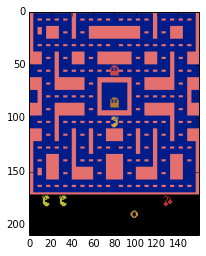

In [232]:
imshow(initial_state, cmap='gray')

In [233]:
h=80
w=80
resized_state_shape = (w,h)

op = ObservationProcessor(resize_to=resized_state_shape)

(80, 80)


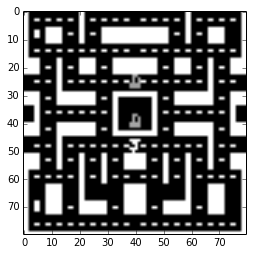

In [234]:
pp = op.process_observation(initial_state )
print pp.shape
# N.B. matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
# let's then remove the channel info for the plot
imshow(np.reshape(pp, (pp.shape[0], pp.shape[1])),
       cmap='gray')

In [235]:
# https://github.com/keras-rl/keras-rl/issues/113
window_length = 4
agent_state_shape = resized_state_shape
print "Agent input shape", agent_state_shape
print "Number of outputs", num_actions

a = Agent("DQN", 
          env_id,
          agent_state_shape, 
          window_length,
          num_actions, 
          Adam(lr=1e-3), metrics=['mae'],
          preprocessor=op)
a.__print_model_summary__()

Agent input shape (80, 80)
Number of outputs 9
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
permute_2 (Permute)          (None, 80, 80, 4)         0         
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 78, 78, 32)        1184      
_________________________________________________________________
dropout_66 (Dropout)         (None, 78, 78, 32)        0         
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 39, 39, 32)        0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 18, 18, 64)        0         
_________________________________________________________________
conv2d_72 (Conv2D)           

In [236]:
np.random.seed(initial_seed)
env.seed(initial_seed)
a.__train__(env, steps=5000000)

Training for 5000000 steps ...
     433/5000000: episode: 1, duration: 3.285s, episode steps: 433, steps per second: 132, episode reward: 24.000, mean reward: 0.055 [0.000, 1.000], mean action: 3.630 [0.000, 8.000], mean observation: 87.394 [54.000, 155.000], loss: --, mean_absolute_error: --, mean_q: --, mean_eps: --
     904/5000000: episode: 2, duration: 2.800s, episode steps: 471, steps per second: 168, episode reward: 28.000, mean reward: 0.059 [0.000, 1.000], mean action: 3.919 [0.000, 8.000], mean observation: 87.416 [54.000, 155.000], loss: --, mean_absolute_error: --, mean_q: --, mean_eps: --
    1385/5000000: episode: 3, duration: 2.879s, episode steps: 481, steps per second: 167, episode reward: 26.000, mean reward: 0.054 [0.000, 1.000], mean action: 4.137 [0.000, 8.000], mean observation: 87.411 [54.000, 155.000], loss: --, mean_absolute_error: --, mean_q: --, mean_eps: --
    1854/5000000: episode: 4, duration: 3.015s, episode steps: 469, steps per second: 156, episode rew

In [237]:
np.random.seed(initial_seed)
env.seed(initial_seed)
a.__test__(env, episodes=5, visualize=False)

Testing for 5 episodes ...
Episode 1: reward: 7.000, steps: 443
Episode 2: reward: 7.000, steps: 443
Episode 3: reward: 7.000, steps: 443
Episode 4: reward: 7.000, steps: 443
Episode 5: reward: 7.000, steps: 443


In [239]:
a.__replay__(env, condition=(lambda info : info is None or info['ale.lives'] > 2))

Total reward 240.0


In [241]:
env.close()